Note: Predicting order returns can be found in the modelling file in the Google Drive.

## 1) Loading the data

**NOTE: The training data is the BADS_WS1819_training.csv file which has labels associated with it whereas the BADS_WS1819_test.csv does not. For the purposes of our project, we will only be working with BADS_WS1819_training.csv as that is the only way for us to evaluate our models. Therefore, this data will be split into training and test data with a 80:20 split, respectively.**

#### 1.1) Importing the necessary libraries

In [1]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn
import altair as alt
from scipy import stats


from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer

#### 1.2) Mounting the Google Drive folder

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
base_path = '/content/gdrive/MyDrive/DSBD_Project2/Deliverables/Intermediate/Dataset/'

Mounted at /content/gdrive


#### 1.3) Reading the file as a dataframe

In [3]:
training_df= pd.read_csv(base_path+'BADS_WS1819_training.csv') 
training_df

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
0,ID1,2016-05-13,2016-05-16,1040,38,red,138,69.9,19065,Mrs,NaN,Lower Saxony,2016-05-14,1
1,ID2,2016-09-26,NaN,4490,m,grey,133,59.9,32349,Mrs,1967-02-21,North Rhine-Westphalia,2015-02-17,0
2,ID3,2017-02-28,2017-05-09,4792,m,ecru,128,99.9,74743,Mrs,NaN,North Rhine-Westphalia,2017-02-14,0
3,ID4,2017-01-23,2017-01-24,4686,L,terracotta,105,59.9,32935,Mrs,1961-01-08,North Rhine-Westphalia,2015-02-17,0
4,ID5,2016-05-13,2016-05-16,648,39,petrol,170,139.9,2842,Mrs,1966-05-01,Schleswig-Holstein,2015-04-06,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,ID99996,2016-11-23,2016-11-26,2942,m,mocca,103,39.9,61523,Mrs,1965-02-25,Saarland,2016-11-09,0
99996,ID99997,2016-05-17,2016-05-18,468,l,red,125,39.9,16376,Mrs,1964-03-20,Bavaria,2015-02-17,1
99997,ID99998,2016-08-06,2016-08-08,2804,l,white,103,26.9,8568,Mrs,1966-10-26,Bavaria,2015-05-15,0
99998,ID99999,2016-05-12,2016-05-15,382,l,red,103,29.9,18847,Mrs,1964-02-24,Thuringia,2015-02-17,0


## 2) Understanding the data

#### 2.1) Understanding the data statistics

In [4]:
training_df.describe() 

,item_id,brand_id,item_price,user_id,return
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2799.935460,129.865530,70.279144,33423.093120,0.481740
std,1862.591355,30.145314,44.973992,23962.095319,0.499669
min,4.000000,101.000000,0.000000,6.000000,0.000000
25%,666.000000,105.000000,34.900000,12944.000000,0.000000
50%,3140.000000,122.000000,59.900000,28472.000000,0.000000
75%,4686.000000,143.000000,89.900000,51219.000000,1.000000
max,6144.000000,266.000000,399.950000,86609.000000,1.000000


- An interesting thing to note here is that **48.17% of the orders in the training got returned** which further depicts the importance of predicting order returns for online retailers. 

- **From this we also learn that the data is not imbalanced as the target variables values are approximately 50%**

#### 2.2) Finding the number of unique values in each column

In [5]:
for col in training_df:
    print(col,len(training_df[col].unique()))

order_item_id 100000
order_date 365
delivery_date 320
item_id 2656
item_size 114
item_color 85
brand_id 155
item_price 332
user_id 37663
user_title 5
user_dob 12122
user_state 16
user_reg_date 775
return 2


- The company has 2656 different items and 155 different brands as part of their product offerings. 
- This data consists of 100000 orders.
- The company has 37663 customers who are from 16 different states.

- item_size has a high number of unique values which is worth looking at. 
- Even user_title might be worth looking at.

##### 2.2.1) Analyzing item_size further

In [6]:
training_df.item_size.unique() 

array(['38', 'm', 'L', '39', '46', '40', '41', '8', 'XL', '43+', '44',
       's', 'unsized', 'l', 'XXL', '50', '37', 'M', 'xl', 'xxl', '48',
       '42', '36', '35', 'S', '8+', '6+', '6', '33', '45', '11', '34',
       '28', '4+', '9+', '5+', '18', '23', '38+', '7', '43', '4', '9',
       '20', '19', '22', '56', 'XXXL', '39+', '13', '42+', '32', '10',
       '41+', '7+', '152', '140', '5', '27', '2', '104', '44+', '37+',
       '26', '21', '10+', '1', '31', '3632', '96', '4032', '176', '128',
       '30', 'xs', '12+', '116', '24', '40+', '12', 'xxxl', '52', '25',
       '29', '3', '36+', '92', '47', '54', '46+', '3432', '164', '11+',
       '3+', '88', '3832', '2+', 'XS', '3332', '90', '80', '3334', '84',
       '45+', '3634', '100', '3834', '14', '3434', '58', '76', '95',
       '2932', '105'], dtype=object)

- Column item_size consists of categorical and numerical values along with some outliers like '3434' and '40+' and we will need to find a way to normalize these as item_size would have an impact on why people return online orders.

##### 2.2.2) Analyzing user_title further

In [7]:
training_df.user_title.unique() 

array(['Mrs', 'Mr', 'Family', 'not reported', 'Company'], dtype=object)

In [8]:
training_df.user_title.value_counts()

Mrs             95976
Mr               3500
Family            375
Company            78
not reported       71
Name: user_title, dtype: int64

- Family, Company and not reported values are very small compared to Mr and Mrs.

- Additionally, gender might impact order returns and since, Family, Company and Not Reported would not provide us with this data, we consider them as outliers and will get rid of them.

#### 2.3) Finding the number of NaNs in each column

In [9]:
for col in training_df:
    print(col,training_df[col].isna().sum()) 

order_item_id 0
order_date 0
delivery_date 8292
item_id 0
item_size 0
item_color 0
brand_id 0
item_price 0
user_id 0
user_title 0
user_dob 10023
user_state 0
user_reg_date 0
return 0


**Delivery date and user_dob are the columns that have NaNs**

## 3) Key Takeaways after eyeballing the dataset
* **order_item_id** is a unique field in the dataset and it has a unique value for each order. In that case it is not important for our predictions and hence can be dropped.

* **brand_id, item_id, user_id** are unique in terms of their respective labels but could have some impact on returns. However, our models will not be able interpret them as they are numerical values and converting them to categorical values using one-hot encoding will blow up the data. 

  Additionally, if the test data has new users, items or brands, there will be a problem of data leakage which however can be resolved using Laplace smoothing but we will drop these columns due to the first reason.

* Having a look at the number of null values in each column we can see that **delivery_date** has a total of ***8292*** null values and **user_dob** has a total of ***10023*** null values. One way of imputing values for these columns would be to compute the days_between_order_and_delivery and user_age_at_order_date, respectively and then, using MICE or kNN imputation to fill those values. While these may lead to some inaccurate results, these features could be important in predicting product returns.

* Date Columns like **order_date** and **delivery_date** can be feature engineered to extract individual day and month values. We can do that and see if there is a correlation between the target variable and these extracted features. Having year may not add as much value because every year the trend can change and we will concentrate on the days and the months across all years of the training data to check if those affect order returns. 

* **user_dob** and **user_reg_date** can be converted to integer values. For instance we can get the age of the user at the time of ordering by using the year value of the order date and year value in the user_dob column. For user_reg_date we can extract and see how many years a user has been registered for at the time of ordering. 

* Something odd is occuring in the unique values taken up by the **item_size** column, after observing the values above we can see that we have large integer values (ex. 3632), odd values like 40+ and a mix of string and integer values which do not make sense and most of the large values are occuring only once in the data. To standardize this we will convert these values to categorical ones which are used on a daily basis such as: 'xxs', xs','s','m','l','xl','xxl','xxxl' and then use one-hot encoding. 'unsized' orders will be dropped.

* **user_title** consists of 5 different String values: 'Mr','Mrs','Family','Company' and 'not reported'. The latter 3 will be removed to use gender as a feature for the models. Also, they sum upto ~500 rows out of the 100k rows, which is okay. 

* **user_state** being a string column consists of states in Germany, now since there only 16 unique values we can use one hot encoding for this feature as some if not most of the Machine Learning models we will be using later require numerical values.  

**Note: Why one-hot encoding?**
For categorical variables where no ordinal relationship exists, the integer encoding may not be enough, at best, or misleading to the model at worst.

Forcing an ordinal relationship via an ordinal encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results (predictions halfway between categories).

## 4) Data Visualization 

Before we enter the domain of feature engineering, let's understand our training data further using visualizations to see if we find some interesting patterns we can make use of for our predictive modelling

#### 4.1) Visualizing pricing ranges for product returns 

##### 4.1.1) We will visualize the range of price for which the product returns (and non-returns) are the most.

In [10]:
sample_size = 10 ** 5
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [11]:
def visualize_price_ranges(df,return_val):
  '''
  Takes in the dataframe and the value that that says returned or not
  and returns the price ranges for plotting
  '''
  training_df_1= training_df[training_df['return']==return_val]
  price_df = training_df_1[['order_item_id', 'item_price']]
  price_bins = pd.cut(price_df['item_price'], bins=5)
  price_bins = price_bins.groupby(price_bins)
  price_bins = price_bins.count().to_frame(name='count').reset_index()
  price_bins['item_price'] = price_bins['item_price'].astype(str).str.extract(r'(\d*\.\d+)')
  return price_bins

In [12]:
price_bins_1= visualize_price_ranges(training_df,1)
price_chart = alt.Chart(price_bins_1).mark_bar().encode(
      alt.X('item_price:N', bin=True, title='Prices(Dollars)'),
      alt.Y('count:Q', title='count')
  ).properties(
      title = "Price Range for which return=1 - Returns decrease as prices increases",
      width=400,
      height=300
  )
price_chart

alt.Chart(...)

In [13]:
price_bins_1= visualize_price_ranges(training_df,0)
price_chart = alt.Chart(price_bins_1).mark_bar().encode(
      alt.X('item_price:N', bin=True, title='Prices(Dollars)'),
      alt.Y('count:Q', title='count')
  ).properties(
      title = "Price Range for which return=0 - Returns decrease as prices increases",
      width=400,
      height=300
  )
price_chart

alt.Chart(...)

- Most of the product counts are for products that are priced low which depicts that most of the sales of the online retailer come from lower priced products. 

#### 4.2) Visualizing user_title
- We will briefly see the count of returns for each user_title 

In [14]:
training_df_1= training_df[training_df['return']==1]
title_chart = alt.Chart(training_df_1.sample(5000)).mark_bar().encode(
    alt.X('user_title:O', title='User Title'),
    y = alt.Y('count()', title='Return Count')
).properties(
    title='Women have the highest count for returned orders followed by men',
    width=400,
    height=300
)

title_chart

alt.Chart(...)

- Title "Mrs" seem to have maximum product returns hence apart from predictive analytics this is another useful observation for our online retailer.

####  4.3) Visualizing distribution of returns by state

In [15]:
state_chart = alt.Chart(training_df_1.sample(5000)).mark_bar().encode(
    alt.X('user_state:O', title='State Name'),
    y = alt.Y('count()', title='Return Count')
).properties(
    title='North Rhine-Westphalia has the highest number of order returns',
    width=400,
    height=300
)

state_chart

alt.Chart(...)

- There is one state that stands out with regards to Product Returns and that is North-Rhine-Westphalia. Using this geographic information retailers can allocate resources to such locations where returns are more. 

## Visualizing outliers

This can only be done for the 'price' column in our dataset

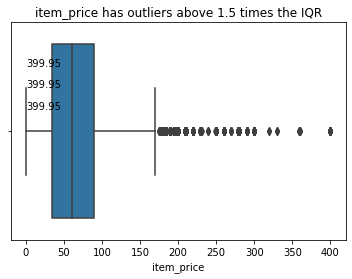

In [16]:
feature = training_df['item_price']
seaborn.boxplot(feature)

# Print the three highest values
highest_vals = sorted(feature,reverse=True)[:3] # get 3 highest values

smallest_val = min(feature)

plt.text(smallest_val, -0.3, highest_vals[0])
plt.text(smallest_val, -0.2, highest_vals[1])
plt.text(smallest_val, -0.1, highest_vals[2])
plt.title('item_price has outliers above 1.5 times the IQR')
plt.show()


Note: Some features that will be computed later on will be visualized in a similar manner.

## 5) Cleaning the Data and adding additional features
Steps:
1. Convert date columns to datetime. Extract year, month and day for each date column.
2. Convert state column to numerical using One Hot Encoding. 
3. Clean color column and convert Color column to numerical using One Hot Encoding.
4. Extracting additional delivery features 
5. Get user wise count and add a new column new_user to keep track of new users 
6. Item discounted or not (Adding isDiscounted column)
7. Drop certain values from user_title and convert to numerical values
8. Dropping unwanted columns
9. Normalizing item size and converting the values to numerical using One Hot Encoding. 
10. Handling null values and outliers of added features.
11. Performing feature scaling 


**Note: Functions have been created for each step and a parent data prep function calls them in sequence**

**Note 2: Steps 10 and 11 have been called after executing the parent function because they required some data checks**

#### 5.1) Convert date columns to datetime. Extract year, month, and day for each date column. 



In [17]:
#extracting month, year and day 
def extract_dates(df):
  '''
  Takes in the dataframe and runs a for loop on date_cols
  and extracts the day, month, and year for each of the columns.
  Adds these columns to the dataframe and returns the dataframe.
  '''
  date_cols=["order_date", "delivery_date", "user_reg_date"]
  for col_name in date_cols:    
      df[col_name]= df[col_name].apply(pd.to_datetime)          
      df[col_name+"_year"] = df[col_name].dt.year
      df[col_name+"_month"] = df[col_name].dt.month
      df[col_name+"_day"]= df[col_name].dt.day
  return df

#### 5.2) Convert state column to numerical using OHE 

In [18]:
def state_OHE(df):
  '''
  Takes in the dataframe and using LabelEncoder creates and adds 
  state_labels to the dataframe. Then, uses these labels for 
  one-hot encoding the state labels and adds columns for each
  state to the dataframe. Returns the one-hot encoded dataframe
  '''
  # transform and map states
  state_LE = LabelEncoder()
  state_labels = state_LE.fit_transform(df['user_state'])
  df['state_label'] = state_labels
  
  # encode color labels using one-hot encoding scheme
  state_OHE = OneHotEncoder()
  state_feature_arr = state_OHE.fit_transform(
                                df[['state_label']]).toarray()
  state_feature_labels = list(state_LE.classes_)
  state_features = pd.DataFrame(state_feature_arr, 
                              columns=state_feature_labels)
  df_ohe = pd.concat([df, state_features], axis = 1)
  return df_ohe

#### 5.3) Clean color column and convert Color column to numerical using OHE

In [19]:
def clean_colors_column(df):
  '''
  Takes in the dataframe and cleans the mispelled color names.
  Returns the clean dataframe.
  '''
  #Cleaning mispelled color names 
  df.loc[df['item_color'] == 'blau', 'item_color'] = 'blue'
  df.loc[df['item_color'] == 'brwon', 'item_color'] = 'brown'
  df.loc[df['item_color'] == 'oliv', 'item_color'] = 'olive'
  df.loc[df['item_color'] == 'dark oliv', 'item_color'] = 'dark olive'
  df.loc[df['item_color'] == '?', 'item_color'] = 'unknown'
  return df

In [20]:
def color_OHE(df):
  '''
  Takes in the dataframe and using LabelEncoder creates and adds 
  color_labels to the dataframe. Then, uses these labels for 
  one-hot encoding the color labels and adds columns for each
  color to the dataframe. Returns the one-hot encoded dataframe
  '''
  # transform and map colors
  color_LE = LabelEncoder()
  color_labels = color_LE.fit_transform(df['item_color'])
  df['color_label'] = color_labels
  
  # encode color labels using one-hot encoding scheme
  color_OHE = OneHotEncoder()
  color_feature_arr = color_OHE.fit_transform(
                                df[['color_label']]).toarray()
  color_feature_labels = list(color_LE.classes_)
  color_features = pd.DataFrame(color_feature_arr, 
                              columns=color_feature_labels)
  df_ohe = pd.concat([df, color_features], axis = 1)
  
  return df_ohe

#### 5.4) Extracting additional delivery features
* Extract approximate days to delivery using delivery_date - order_date
* Extract approximate user age using user_dob - order_date
* Extract approximate membership age using user_reg_date - order_date

In [21]:
def extract_additional_features(df):
  '''
  Takes in the dataframe, creates new columns 'user_dob', 'user_reg_date',
  'approximate_days_to_delivery', 'approximate_user_age', 'approximate_user_membership_age_days',
  ensures there are no negative values for 'approximate_user_membership_age_days' 
  by setting them to 0 and returns the updated dataframe.
  '''
  df['user_dob']= df['user_dob'].apply(pd.to_datetime,format='%Y-%m-%d')
  df['user_reg_date']= df['user_reg_date'].apply(pd.to_datetime,format='%Y-%m-%d')
  #Subtracting delivery date and order date values to get approximate days to delivery 
  df['approximate_days_to_delivery'] =  (df.delivery_date - df.order_date).dt.days
  df['approximate_user_age'] =  df.order_date.dt.year - df.user_dob.dt.year 
  df['approximate_user_membership_age_days'] = ((df.order_date) - (df.user_reg_date)).dt.days
  df.loc[df['approximate_user_membership_age_days'] == -1, 
         'approximate_user_membership_age_days'] = 0

  return df

#### 5.5) Get user wise count and add a new column new_user to keep track of new users 

In [22]:
def new_user_features(df):
  '''
  This function checks if a user exists in the data. If yes, assigns 1 else 0
  in the 'new_user_check' column. Returns the updated dataframe.
  '''
  user_wise_count = df['user_id'].value_counts()
  x_count = list(user_wise_count.index)
  y_count = list(user_wise_count.values)
  user_dict_count = dict(zip(x_count, y_count))
  df['count_user'] = df['user_id'].map(user_dict_count)
  df['new_user_check'] = df.apply(lambda x: 1 if x['count_user'] <= 1 else 0, axis = 1)
  
  return df

#### 5.6) Item discounted or not

In [23]:
def item_discounted_feature(df):
  '''
  This function checks if the item was sold at a discounted price
  based on its average price. Assigns 1 if yes, else 0 using the 
  discounted column. Returns the updated dataframe.
  '''
  df['avg_price_per_item']= df.groupby(['item_id'])['item_price'].transform('mean')
  df['item_discounted_diff']=df['avg_price_per_item'] - df['item_price']
  df['discounted']= df.apply(lambda x: 1 if x['item_discounted_diff']>0 else 0,axis=1)
  return df

#### 5.7) Drop certain values from user_title and convert to numerical values

In [24]:
def user_title_handling(df):
  '''
  This function removes rows in the df which have 
  user_titles: 'Company', 'Family' or 'not reported'.
  For the rest of the rows assigns 0 if user_title is 
  'Mr' else, 1. Renames the user_title column to gender
  and returns the updated dataframe.
  '''
  #define list of values
  values = ['Company', 'Family', 'not reported']
  #drop any rows that have 'Company' or 'Family' or 'not reported' in the rebounds column
  df = df[df.user_title.isin(values) == False]
  df['user_title'] = df['user_title'].apply(lambda x: 0 if x == 'Mr' else 1) # Gender 0 if male, 1 if female
  df= df.rename(columns={"user_title": "gender"})

  return df

#### 5.8) Dropping unwanted columns

In [25]:
def drop_cols(df):
  '''
  This function drops the unwanted columns from the dataframe and returns it.
  '''
  cols_to_drop=['order_item_id','order_date','delivery_date','item_color',
                'user_dob','user_state','user_reg_date','state_label',
                'color_label','avg_price_per_item','item_discounted_diff','count_user',
                'delivery_date_year', 'delivery_date_day','order_date_year', 'order_date_day',  'delivery_date_month', 'user_reg_date_year',
                'user_reg_date_month','user_reg_date_day','user_id','brand_id','item_id'] # Dropping item_size for now

  df.drop(columns=cols_to_drop,inplace=True)
  return df 

#### 5.9) Normalizing item size and converting the values to numerical using One Hot Encoding.

In [26]:
def normalize_item_size(item_size):
  '''
  This function takes in item_size and normalizes all item_sizes between XXS-XXXL 
  with the assumption that all items are tshirts or shirts.
  # Assumed conversion
  # XXS: 30-31
  # XS: 32-33
  # S: 34-35
  # M: 36-37
  # L: 38-41
  # XL: 42-43
  # XXL: 44-45
  # XXXL: 46-47

  Returns normalized_item_size for item_sizes that have been converted to ordinal values
  or item_size.upper() for those that have not been.
  '''
  
  normalized_item_size = 0
  if item_size.isdigit():
    
    if len(item_size) > 2:
      item_size = item_size[:2] # if the item size is greater than 2 digits select only the first two digits
                                # assuming the extra digits were added in error
    item_size = int(item_size)
    if item_size < 30 or item_size > 47: # assign 0 to item with size less than 30 and greater than 47 for removal later
      normalized_item_size = 0
      return normalized_item_size

    # converting size from numerical to ordinal
    elif item_size >= 30 and item_size < 32:
      normalized_item_size = 'XXS'
      return normalized_item_size

    elif item_size >= 32 and item_size < 34:
      normalized_item_size = 'XS'
      return normalized_item_size

    elif item_size >= 34 and item_size < 36:
      normalized_item_size = 'S'
      return normalized_item_size

    elif item_size >= 36 and item_size < 38:
      normalized_item_size = 'M'
      return normalized_item_size

    elif item_size >= 38 and item_size < 42:
      normalized_item_size = 'L'
      return normalized_item_size

    elif item_size >= 42 and item_size < 44:
      normalized_item_size = 'XL'
      return normalized_item_size
    
    elif item_size >= 44 and item_size < 46:
      normalized_item_size = 'XXL'
      return normalized_item_size

    elif item_size >= 46 and item_size < 48:
      normalized_item_size = 'XXXL'
      return normalized_item_size

  else: # if string is not a digit
    if item_size == 'unsized': # assigning 0 to items that are unsized for removal later
      normalized_item_size = 0
      return normalized_item_size
    if '+' in item_size: # removing + from numerical item_size and converting them to ordinal values
      item_size = item_size.replace('+','')
      item_size = int(item_size)
      if item_size < 30 or item_size > 47:
        normalized_item_size = 0
        return normalized_item_size

      elif item_size >= 30 and item_size < 32:
        normalized_item_size = 'XXS'
        return normalized_item_size

      elif item_size >= 32 and item_size < 34:
        normalized_item_size = 'XS'
        return normalized_item_size

      elif item_size >= 34 and item_size < 36:
        normalized_item_size = 'S'
        return normalized_item_size

      elif item_size >= 36 and item_size < 38:
        normalized_item_size = 'M'
        return normalized_item_size

      elif item_size >= 38 and item_size < 42:
        normalized_item_size = 'L'
        return normalized_item_size

      elif item_size >= 42 and item_size < 44:
        normalized_item_size = 'XL'
        return normalized_item_size
      
      elif item_size >= 44 and item_size < 46:
        normalized_item_size = 'XXL'
        return normalized_item_size

      elif item_size >= 46 and item_size < 48:
        normalized_item_size = 'XXXL'
        return normalized_item_size

  return item_size.upper() # returning items that were ordinal values to begin with in upper case


One Hot Encoding item size

In [27]:
def handling_item_size(df):
  '''
  This function removes rows that were assigned an item_size of 0
  and returns the updated dataframe.
  '''
  df['item_size'] = df['item_size'].apply(lambda x: normalize_item_size(x))
  df = df[df.item_size != 0].reset_index(drop = True) # Removing unwanted rows with value 0
  return df

In [28]:
def item_size_OHE(df):
  '''
  Takes in the dataframe and using LabelEncoder creates and adds 
  item_size_labels to the dataframe. Then, uses these labels for 
  one-hot encoding the item_size labels and adds columns for each
  item_size to the dataframe. Returns the one-hot encoded dataframe
  '''
  # transform and map item_size
  item_size_LE = LabelEncoder()
  item_size_labels = item_size_LE.fit_transform(df['item_size'])
  df['item_size_labels'] = item_size_labels
  
  # encode item_size labels using one-hot encoding scheme
  item_size_OHE = OneHotEncoder()
  item_size_feature_arr = item_size_OHE.fit_transform(
                                df[['item_size_labels']]).toarray()
  item_size_feature_labels = list(item_size_LE.classes_)
  item_size_features = pd.DataFrame(item_size_feature_arr, 
                              columns=item_size_feature_labels)
  df_ohe = pd.concat([df, item_size_features], axis = 1)
  df_ohe.drop(columns='item_size',inplace=True)
  return df_ohe


Parent function to perform initial data preparation 

In [29]:
def parent_data_prep_function(df):
  '''
  This function runs all the functions above sequentially and returns the final
  dataframe.
  '''
  print("------------------1. Extracting Dates-----------------------------------")
  df_step_1= extract_dates(df)
  print("------------------2. OHE State values-----------------------------------")
  df_step_2= state_OHE(df_step_1)
  print("------------------3. Cleaning color column------------------------------")
  df_step_3= clean_colors_column(df_step_2)
  print("------------------4. OHE Color values-----------------------------------")
  df_step_4= color_OHE(df_step_3)
  print("------------------5. Extracting additional delivery days features-------")
  df_step_5= extract_additional_features(df_step_4)
  print("------------------6. Extracting additional user features----------------")
  df_step_6= new_user_features(df_step_5)
  print("------------------7. Extracting Isdiscounted feature--------------------")
  df_step_7=item_discounted_feature(df_step_6)
  print("------------------8. Transforming user_title column---------------------")
  df_step_8= user_title_handling(df_step_7)
  print("------------------9. Dropping unwanted columns--------------------------")
  df_step_9= drop_cols(df_step_8)
  print("------------------10. Handling Item size column-------------------------")
  df_step_10= handling_item_size(df_step_9)
  print("------------------11. OHE Item size column------------------------------")
  df_step_11= item_size_OHE(df_step_10)

  return df_step_11

df_clean= parent_data_prep_function(training_df)

------------------1. Extracting Dates-----------------------------------
------------------2. OHE State values-----------------------------------
------------------3. Cleaning color column------------------------------
------------------4. OHE Color values-----------------------------------
------------------5. Extracting additional delivery days features-------
------------------6. Extracting additional user features----------------
------------------7. Extracting Isdiscounted feature--------------------
------------------8. Transforming user_title column---------------------
------------------9. Dropping unwanted columns--------------------------
------------------10. Handling Item size column-------------------------
------------------11. OHE Item size column------------------------------


#### 5.10) Handling null values and outliers of added features. 

In [30]:
list_cols_with_nulls=[(df_clean.isna().sum().index[x],count) for x,count in enumerate(df_clean.isna().sum()) if count>0]

In [31]:
list_cols_with_nulls

[('approximate_days_to_delivery', 7217), ('approximate_user_age', 8785)]

In [32]:
def imputing_values(df):
  '''
  This function imputes values for rows with missing values
  using the IterativeImputer() and returns the updated 
  dataframe.
  '''
  iterative_imp = IterativeImputer()
  df=iterative_imp.fit_transform(df)
  return df

In [33]:
cols_clean=list(df_clean.columns)

NOTE: The imputer added negative values for days_to_delivery and hence, we will be filtering out those values altogether.

In [34]:
df_imputed = imputing_values(df_clean)

In [35]:
intermediate_df = pd.DataFrame(df_imputed, columns = cols_clean)

In [36]:
intermediate_df['approximate_days_to_delivery']

0         3.00000
1       -66.79291
2        70.00000
3         1.00000
4         3.00000
           ...   
87582    11.00000
87583     3.00000
87584     1.00000
87585     2.00000
87586     3.00000
Name: approximate_days_to_delivery, Length: 87587, dtype: float64

In [37]:
print(max(intermediate_df['approximate_user_age']))
print(min(intermediate_df['approximate_user_age']))

117.0
4.0


As we can see above some user age values seem unrealistic so we will consider a range of 13 to 90 

In [38]:
intermediate_df=intermediate_df[intermediate_df['approximate_user_age'].between(13, 90)]

In [39]:
intermediate_df=intermediate_df.astype('int')
intermediate_df = intermediate_df[~(intermediate_df['approximate_days_to_delivery'] <= 0)]  

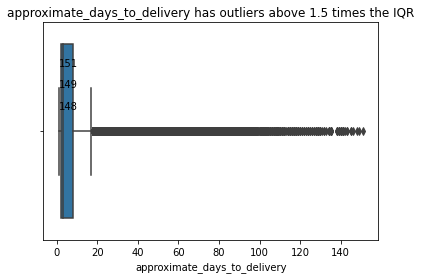

In [40]:
feature = intermediate_df['approximate_days_to_delivery']
seaborn.boxplot(feature)

# Print the three highest values
highest_vals = sorted(feature,reverse=True)[:3] # get 3 highest values

smallest_val = min(feature)

plt.text(smallest_val, -0.3, highest_vals[0])
plt.text(smallest_val, -0.2, highest_vals[1])
plt.text(smallest_val, -0.1, highest_vals[2])
plt.title('approximate_days_to_delivery has outliers above 1.5 times the IQR')
plt.show()

Removing outliers for price and approximate_days_to_delivery using IQR method

In [41]:
cols_outliers=['item_price','approximate_days_to_delivery']
def remove_outliers(df_uncleaned,outlier_cols):
  '''
  This function that in the unclean dataframe and the columns that
  have outliers. It computes the IQR, lower_limit and upper_limit (for outliers)
  and removes datapoints that fall outside the limit variables. Returns the 
  clean dataframe.
  '''
  for col in outlier_cols:
    Q1 = df_uncleaned[col].quantile(0.25)
    Q3 = df_uncleaned[col].quantile(0.75)
    IQR = Q3-Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    df_cleaned = df_uncleaned[(df_uncleaned[col] > lower_limit) & (df_uncleaned[col] < upper_limit)]
  return df_cleaned

df_without_outliers= remove_outliers(intermediate_df,cols_outliers)

In [42]:
df_without_outliers['item_price'].to_csv(base_path+'/Data_clean_price_approximation.csv',index=False)

#### 5.11) Performing feature scaling

In [ ]:
def feature_scaling(df):
  '''
  This function takes in a dataframe, and scales features in the 
  columns defined below using MinMaxScalar(). Returns the updated 
  dataframe.
  '''

  mms = MinMaxScaler()
  df[['item_price', 'approximate_days_to_delivery',
      'approximate_user_age', 
      'approximate_user_membership_age_days']] = mms.fit_transform(df[['item_price',
                                                                      'approximate_days_to_delivery',
                                                                      'approximate_user_age', 
                                                                      'approximate_user_membership_age_days']])
  return df
final_df=feature_scaling(df_without_outliers)

In [ ]:
final_df.to_csv(base_path+'/Data_clean_final.csv',index=False)